In [1]:
# try numpyro for MCMC

# plotting + data handling
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import corner

# numpy 
import numpy as np

# jax for automatic differentiation
import jax
import jax.numpy as jnp
key = jax.random.key(1234)

# numpyro for HMC
import numpyro
num_chains = 8
numpyro.set_host_device_count(num_chains)

In [2]:
# Data

# import data from file
file = "code\1-Fragment_C_Hole_Measurements.csv"

df = pd.read_csv(file)

# just extract ID, X,Y values
data_col = df[["Section ID", "Mean(X)", "Mean(Y)"]]

jax_array = jnp.array(data_col)

# First index for ID, second index for X (1) or Y (2)
X = jax_array[:,1]
Y = jax_array[:,2]

data = [X,Y]


In [3]:
key, subkey = jax.random.split(key)

# model - takes parameters as input & calculates (xi, yi) positions on circle

# R radius of mechanism
# N npoints for whole mechanism
# sigma_r radial error
# sigma_t tangential error - for isotropic model set sigma_r = sigma_t = sigma (uniform x,y error)
# xc central position of x coordinate for each section (x8)
# yc central position of y coordinate for each section (x8)
# a alpha phase shift of each section (x8)

sizes = [1,22,9,37,1,3,2,6] # no. points in each section

# explicitly require separate parameters for xc0,xc1,xc2 etc...

def modelxy(R,N,xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7,a0,a1,a2,a3,a4,a5,a6,a7):
    
    xc = [xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7]
    yc = [yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7]
    a = [a0,a1,a2,a3,a4,a5,a6,a7]

    # duplicate values of xc, yc, alpha, to make array of length 81 (matching no. points) with values corresponding to each section
    # this is equivalent to iterating over [i] which doesn't work in this JAX-numpyro format

    xc_expand = jnp.array([val for val, count in zip(xc, sizes) for _ in range(count)])
    yc_expand = jnp.array([val for val, count in zip(yc, sizes) for _ in range(count)])
    a_expand = jnp.array([val for val, count in zip(a, sizes) for _ in range(count)])
    
    # index points 1-81 with i = [0,80]
    index = jnp.linspace(0,80,81)

    # phase offset for each point from start of its section
    phi = 2 * jnp.pi * index/N  +  (a_expand * jnp.pi/180) # degrees --> radians

    # model (x,y) coordinates
    xi = (R * jnp.cos(phi) + xc_expand)
    yi = (R * jnp.sin(phi) + yc_expand)
    

    return xi,yi


In [ ]:

# Isotropic Model

def numpyro_model_isotropic(X, Y):

    # priors on all parameters for probabilitic programming

    R = numpyro.sample("R", numpyro.distributions.Uniform(60, 100))
    N = numpyro.sample("N", numpyro.distributions.Uniform(340,370))

    xc0 = numpyro.sample("xc0", numpyro.distributions.Uniform(70,90))
    xc1 = numpyro.sample("xc1", numpyro.distributions.Uniform(70,90))
    xc2 = numpyro.sample("xc2", numpyro.distributions.Uniform(70,90))
    xc3 = numpyro.sample("xc3", numpyro.distributions.Uniform(70,90))
    xc4 = numpyro.sample("xc4", numpyro.distributions.Uniform(70,90))
    xc5 = numpyro.sample("xc5", numpyro.distributions.Uniform(70,90))
    xc6 = numpyro.sample("xc6", numpyro.distributions.Uniform(70,90))
    xc7 = numpyro.sample("xc7", numpyro.distributions.Uniform(70,90))

    yc0 = numpyro.sample("yc0", numpyro.distributions.Uniform(130,140))
    yc1 = numpyro.sample("yc1", numpyro.distributions.Uniform(130,140))
    yc2 = numpyro.sample("yc2", numpyro.distributions.Uniform(130,140))
    yc3 = numpyro.sample("yc3", numpyro.distributions.Uniform(130,140))
    yc4 = numpyro.sample("yc4", numpyro.distributions.Uniform(130,140))
    yc5 = numpyro.sample("yc5", numpyro.distributions.Uniform(130,140))
    yc6 = numpyro.sample("yc6", numpyro.distributions.Uniform(130,140))
    yc7 = numpyro.sample("yc7", numpyro.distributions.Uniform(130,140))

    a0 = numpyro.sample("a0", numpyro.distributions.Uniform(-150,-140))
    a1 = numpyro.sample("a1", numpyro.distributions.Uniform(-150,-140))
    a2 = numpyro.sample("a2", numpyro.distributions.Uniform(-150,-140))
    a3 = numpyro.sample("a3", numpyro.distributions.Uniform(-150,-140))
    a4 = numpyro.sample("a4", numpyro.distributions.Uniform(-150,-140))
    a5 = numpyro.sample("a5", numpyro.distributions.Uniform(-150,-140))
    a6 = numpyro.sample("a6", numpyro.distributions.Uniform(-150,-140))
    a7 = numpyro.sample("a7", numpyro.distributions.Uniform(-150,-140))

    # bundle all parameters:

    params = R,N,xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7,a0,a1,a2,a3,a4,a5,a6,a7

    # sigma_x = sigma_y so just use one sigma acting on both X and Y

    sigma = numpyro.sample("sigma", numpyro.distributions.Normal(0, 0.5))

    with numpyro.plate("data", X.shape[0]):

        # model predictions for (X,Y)
        Xi, Yi = modelxy(*params)


        numpyro.sample("obs_X", numpyro.distributions.Normal(Xi, sigma), obs=X)
        numpyro.sample("obs_Y", numpyro.distributions.Normal(Yi, sigma), obs=Y)




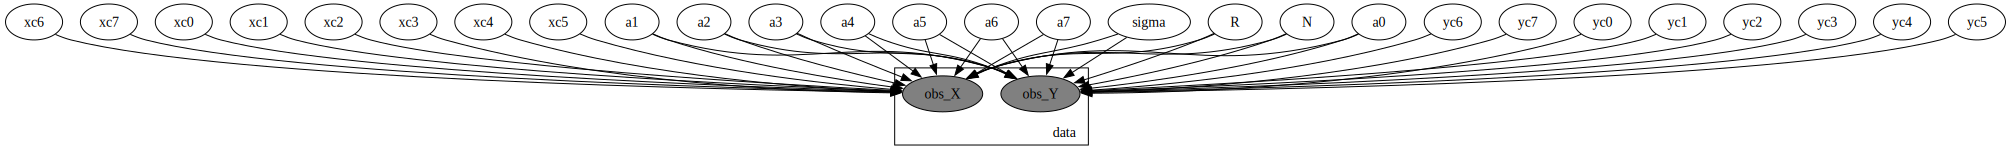

In [5]:
# visualise model

numpyro.render_model(numpyro_model_isotropic, model_args=(X,Y))

In [6]:
# Run MCMC on isotropic model

nuts_kernel = numpyro.infer.NUTS(numpyro_model_isotropic)
mcmc_isotropic = numpyro.infer.MCMC(nuts_kernel, num_warmup=100, num_samples=1000, num_chains=8)
#key, subkey = jax.random.split(key)
mcmc_isotropic.run(subkey, X,Y)
mcmc_isotropic.print_summary()

/tmp/ipykernel_4114764/3337945293.py:4: UserWarning: There are not enough devices to run parallel chains: expected 8 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(8)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_isotropic = numpyro.infer.MCMC(nuts_kernel, num_warmup=100, num_samples=1000, num_chains=8)
sample: 100%|██████████| 1100/1100 [00:16<00:00, 66.33it/s, 1023 steps of size 4.90e-03. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         N    355.73      3.95    355.64    349.27    362.39   1667.15      1.00
         R     77.44      0.85     77.42     76.07     78.90   1663.71      1.00
        a0   -146.09      2.25   -146.11   -149.68   -142.68   1739.14      1.01
        a1   -145.69      0.18   -145.69   -145.99   -145.39   2588.02      1.00
        a2   -145.64      0.61   -145.63   -146.61   -144.61   4022.87      1.00
        a3   -145.48      0.57   -145.49   -146.39   -144.51   1697.33      1.00
        a4   -145.04      2.91   -145.09   -149.32   -140.29   3602.31      1.00
        a5   -146.09      2.25   -146.25   -150.00   -142.93   4223.89      1.00
        a6   -145.25      2.75   -145.38   -149.95   -141.26   2553.06      1.00
        a7   -147.63      1.20   -147.69   -149.77   -145.90   2692.33      1.00
     sigma      0.09      0.01      0.09      0.09      0.10   6443.85      1.00
       xc0     79.82      1

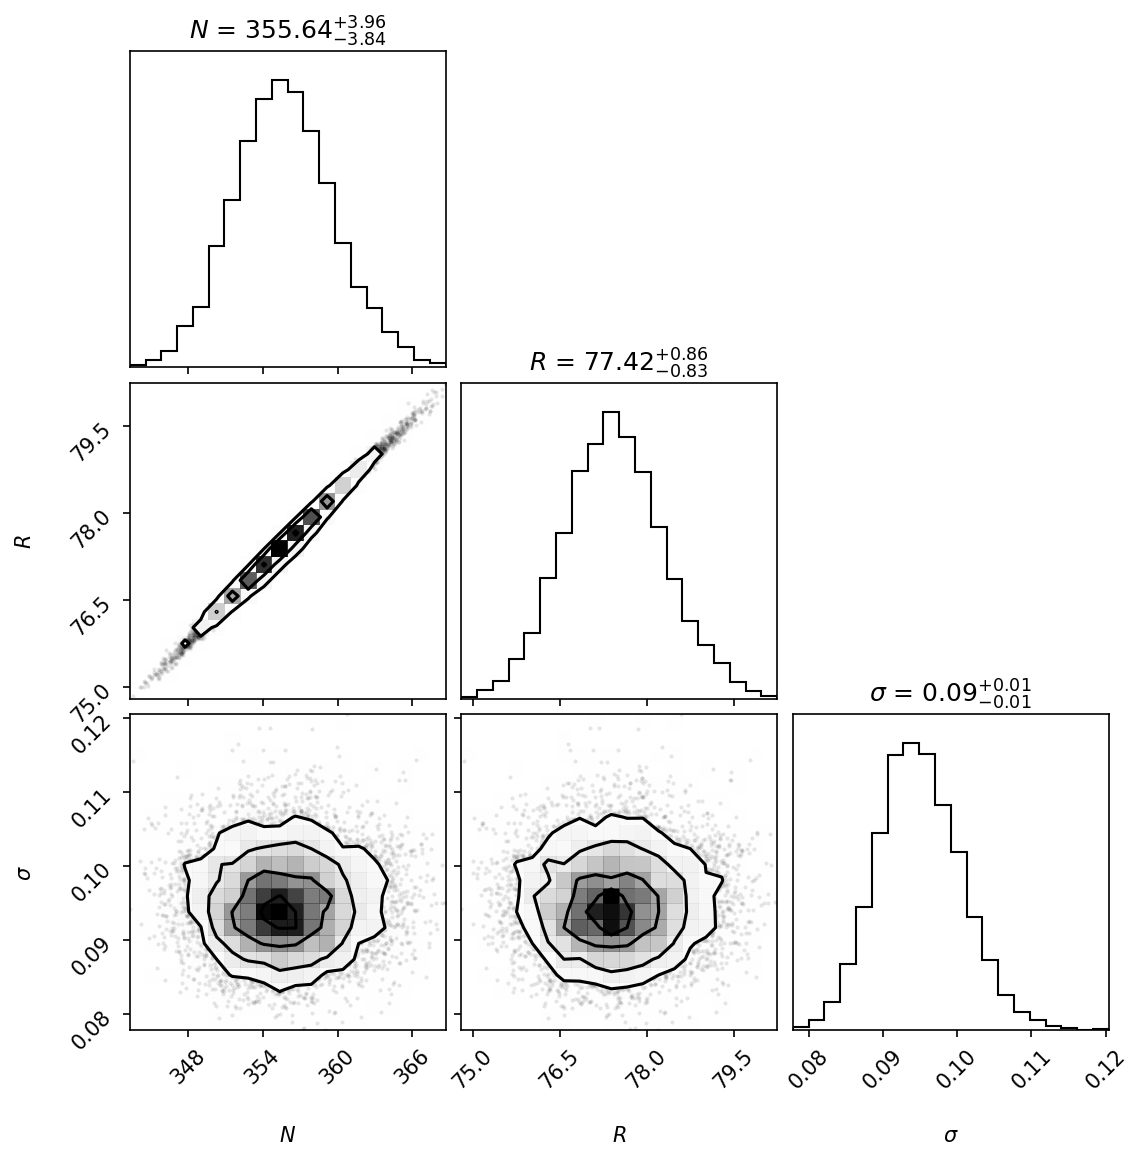

In [7]:
samples_isotropic = mcmc_isotropic.get_samples()

fig = plt.figure(figsize=(8, 8), dpi=150)  # Higher DPI and larger figure size
corner.corner(np.array(jnp.vstack((samples_isotropic['N'], 
                                   samples_isotropic['R'],
                                   samples_isotropic['sigma'])).T),
              labels=[r'$N$', r'$R$', r'$\sigma$'], fig=fig, show_titles=True)
plt.show()

In [10]:
# obtain sampling information

import arviz as az

posterior_iso = az.from_numpyro(mcmc_isotropic)

samples_iso = posterior_iso.posterior 

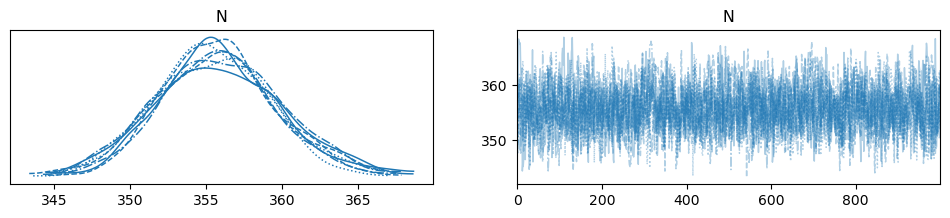

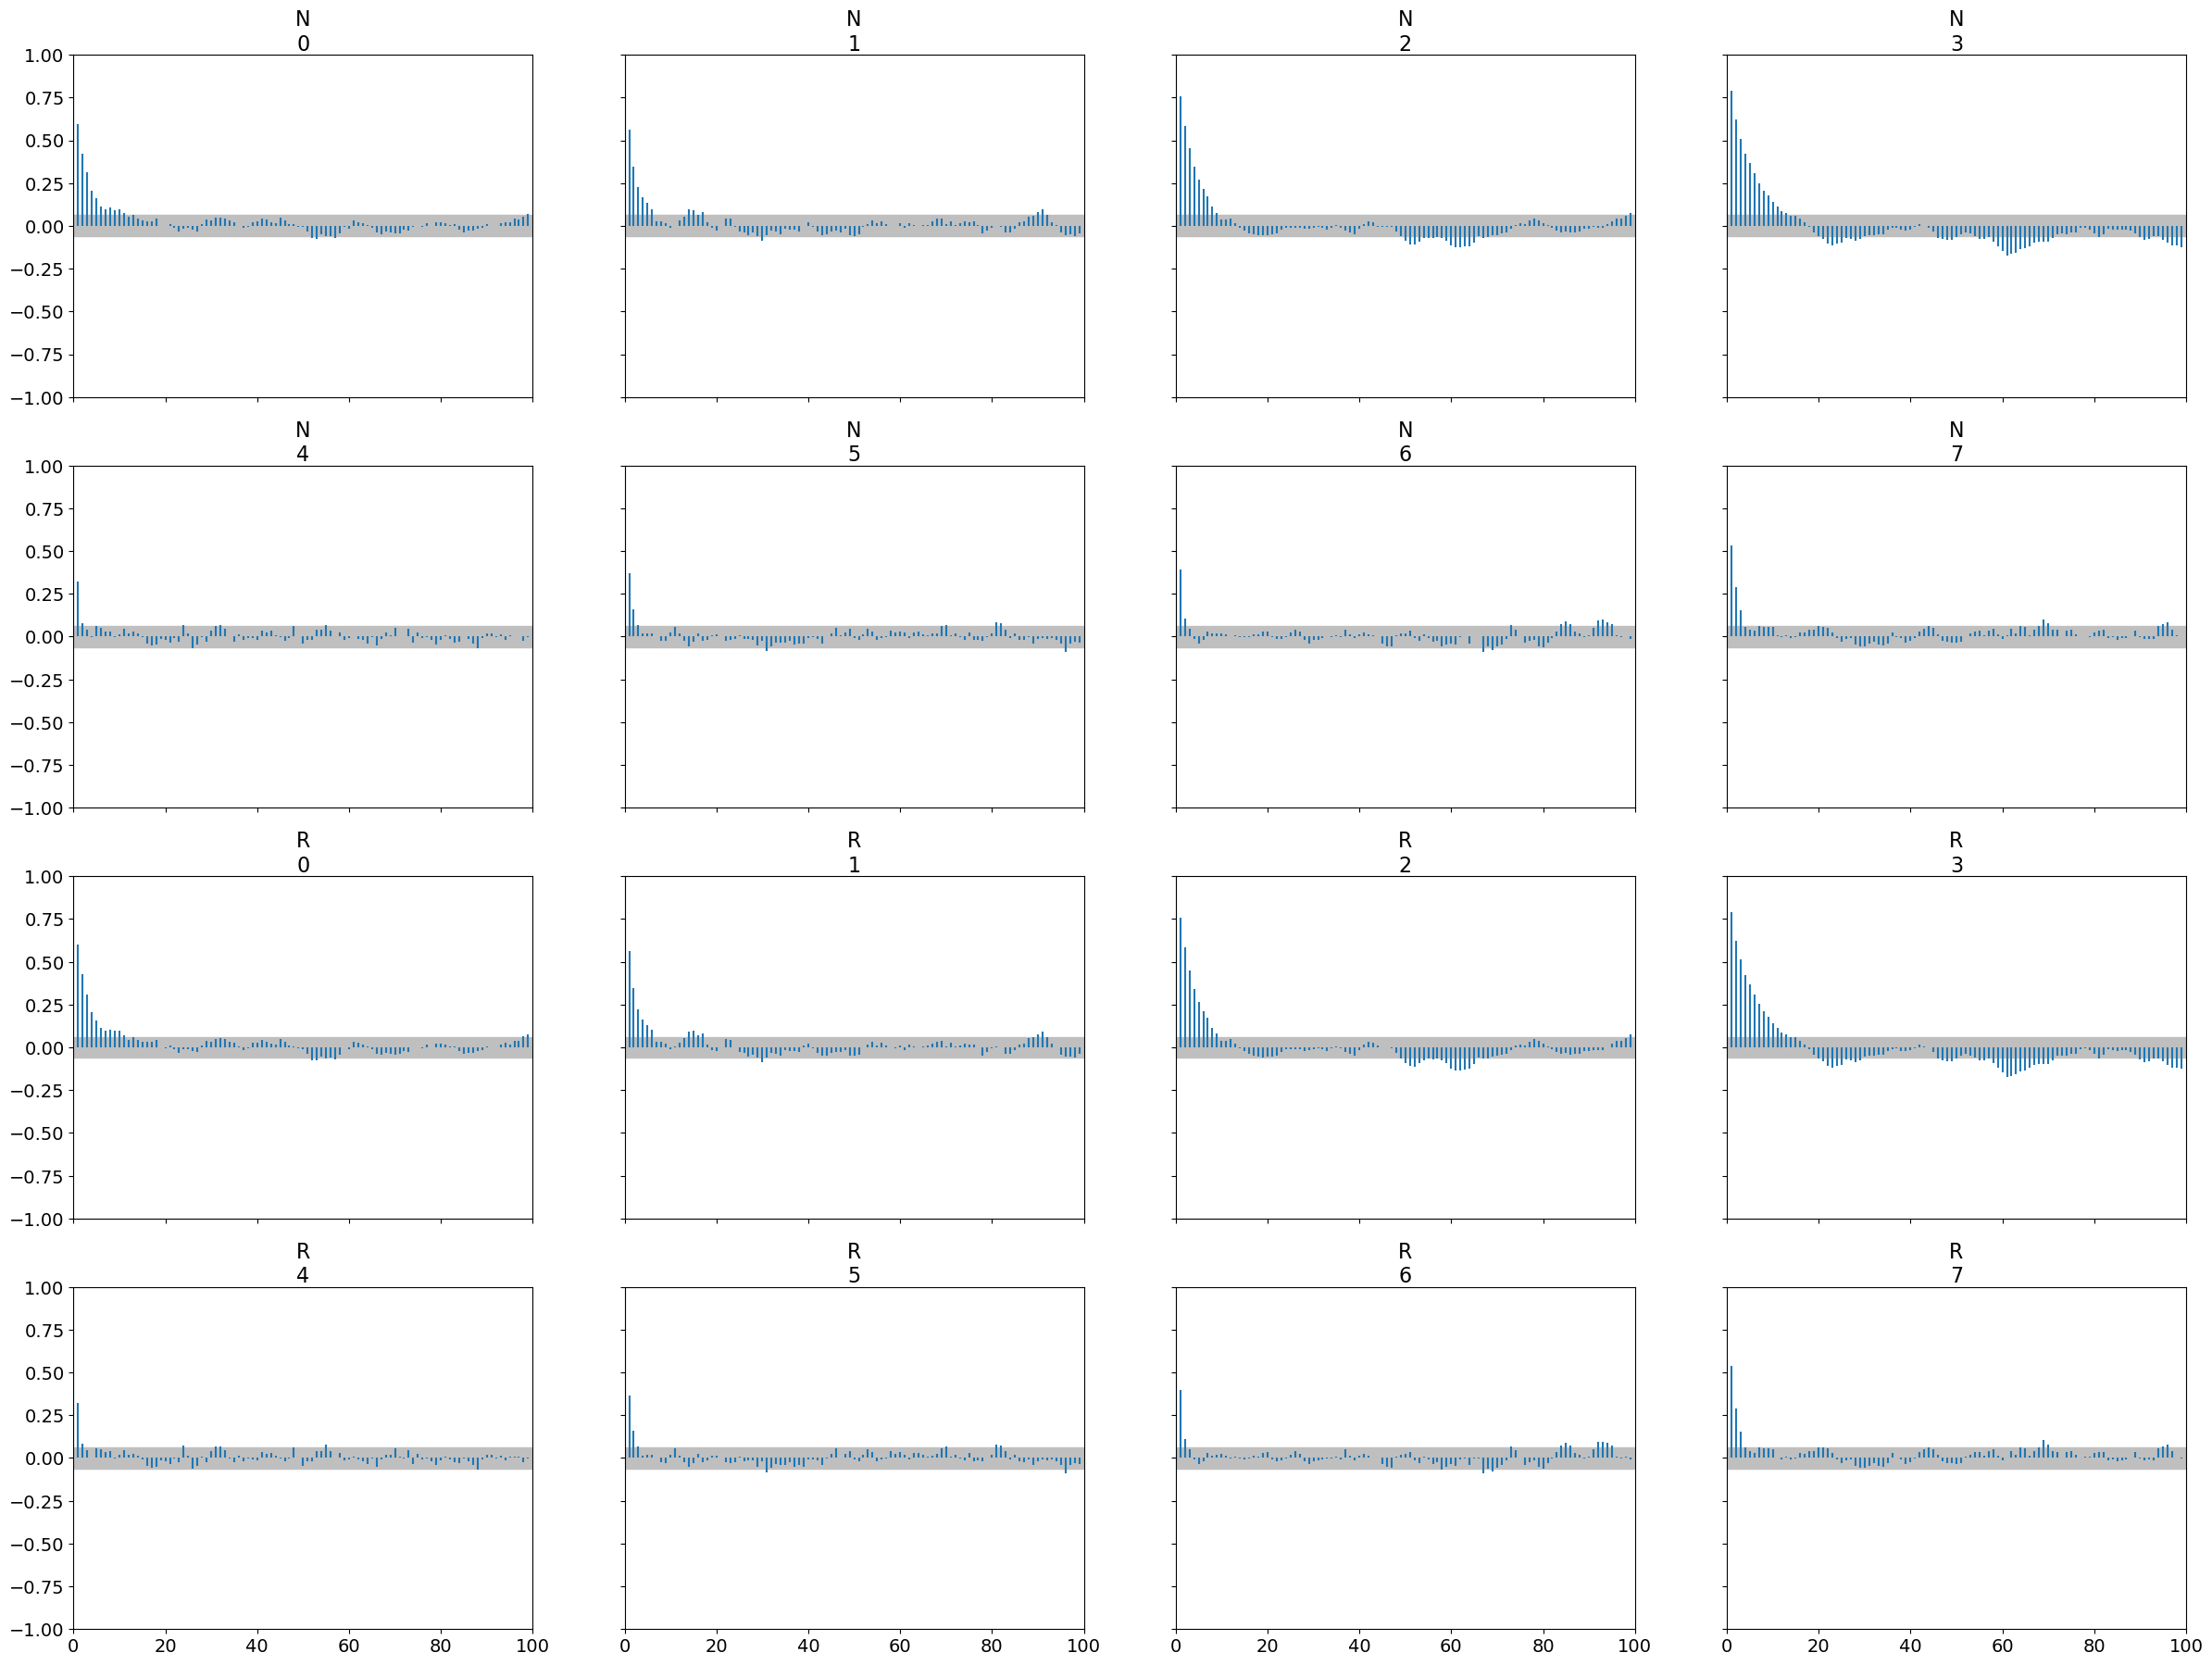

In [11]:
# Trace plot
az.plot_trace(samples_iso, var_names=['N'])

# Plot autocorrelation
az.plot_autocorr(samples_iso, var_names=["N", "R"])
plt.show()

In [12]:
# make latex table of results for credible intervals

def format_latex_table(samples,levels=[68, 90, 95, 99]):
    latex = r"""\begin{tabular}{l c c c c c}
\textbf{parameter} & \textbf{median} & \textbf{68\%} & \textbf{90\%} & \textbf{95\%} & \textbf{99\%}\\
\hline
"""

    for param, values in samples.items():
        median = np.median(values)
        
        row = rf"{{{param}}} & {{{median:.2f}}}"

        for level in levels:
            lower = (100 - level) / 2
            upper = 100 - lower
            ci = np.percentile(values, [lower, upper])

            # Format: median ± difference
            lower_diff = median - ci[0]
            upper_diff = ci[1] - median

            row += rf" & \scriptsize{{\begin{{tabular}}{{@{{}}c@{{}}}}" \
                   rf"$+{upper_diff:.2f}$ \\" \
                   rf"$-{lower_diff:.2f}$" \
                   rf"\end{{tabular}}}}"
            
        latex += r"\vspace{4pt}" + row + r" \\" + "\n" 

    latex += r"\hline" + "\n\\end{tabular}"

    return latex

# Generate LaTeX table
latex_table = format_latex_table(samples_isotropic)

# Save to file
with open("mcmc_results_table_isotropic.tex", "w") as f:
    f.write(latex_table)

print("LaTeX table with vertically aligned small intervals saved to mcmc_results_table.tex")


LaTeX table with vertically aligned small intervals saved to mcmc_results_table.tex


Sample 50 posterior predictive values for hole locations

In [13]:
num_samples = 50

# Get posterior samples from MCMC
posterior_samples = mcmc_isotropic.get_samples()

# Randomly select 50 samples from posterior
indices = jax.random.choice(key, posterior_samples['N'].shape[0], (num_samples,), replace=False)
selected_samples = {k: v[indices] for k, v in posterior_samples.items()}



In [14]:
# remove sigma from samples & run through model

selected_samples

selected_sigma = selected_samples['sigma']

selected_samples


{'N': Array([357.269  , 358.2516 , 355.44968, 352.71228, 358.8783 , 358.58997,
        354.019  , 356.66403, 351.68036, 357.27734, 355.73203, 364.70282,
        360.34973, 358.1783 , 348.7041 , 352.96756, 349.84277, 361.24057,
        351.11893, 353.44135, 353.19156, 358.15582, 357.3999 , 356.28894,
        358.9001 , 362.78772, 353.8522 , 353.55762, 355.61932, 360.7318 ,
        357.29263, 354.8551 , 356.77997, 356.61667, 359.49396, 356.3243 ,
        359.84604, 357.09995, 354.67374, 355.36227, 358.8577 , 351.837  ,
        355.70358, 350.97717, 346.91565, 350.0898 , 353.73782, 357.16675,
        359.1769 , 355.40894], dtype=float32),
 'R': Array([77.86796 , 77.90349 , 77.471695, 76.789635, 78.14192 , 78.14451 ,
        77.06141 , 77.64203 , 76.49042 , 77.63733 , 77.302086, 79.269035,
        78.29633 , 77.94909 , 76.072044, 76.754654, 76.192184, 78.646515,
        76.38313 , 76.9748  , 76.898155, 77.93404 , 77.82436 , 77.70108 ,
        78.11783 , 78.89322 , 77.03374 , 76.997284, 77.

In [15]:
# Extract individual parameters
N = selected_samples['N']
R = selected_samples['R']
a0 = selected_samples['a0']
a1 = selected_samples['a1']
a2 = selected_samples['a2']
a3 = selected_samples['a3']
a4 = selected_samples['a4']
a5 = selected_samples['a5']
a6 = selected_samples['a6']
a7 = selected_samples['a7']
xc0 = selected_samples['xc0']
xc1 = selected_samples['xc1']
xc2 = selected_samples['xc2']
xc3 = selected_samples['xc3']
xc4 = selected_samples['xc4']
xc5 = selected_samples['xc5']
xc6 = selected_samples['xc6']
xc7 = selected_samples['xc7']
yc0 = selected_samples['yc0']
yc1 = selected_samples['yc1']
yc2 = selected_samples['yc2']
yc3 = selected_samples['yc3']
yc4 = selected_samples['yc4']
yc5 = selected_samples['yc5']
yc6 = selected_samples['yc6']
yc7 = selected_samples['yc7']

sigma = selected_samples['sigma']



In [16]:
posteriorxy = []

for i in range(len(N)):
    posteriorxy += modelxy(R[i], N[i], xc0[i], xc1[i], xc2[i], xc3[i], xc4[i], xc5[i], xc6[i], xc7[i], yc0[i], yc1[i], yc2[i], yc3[i], yc4[i], yc5[i], yc6[i], yc7[i], a0[i], a1[i], a2[i], a3[i], a4[i], a5[i], a6[i], a7[i])

In [19]:
# slice the 38th hole 

hole37 = np.array([arr[37] for arr in posteriorxy])

In [20]:
medians = []
for param, values in samples_iso.items():
        medians.append(np.median(values))


[np.float32(355.64206),
 np.float32(77.424774),
 np.float32(-146.11087),
 np.float32(-145.69284),
 np.float32(-145.63348),
 np.float32(-145.48979),
 np.float32(-145.09491),
 np.float32(-146.24622),
 np.float32(-145.38193),
 np.float32(-147.68607),
 np.float32(0.094638705),
 np.float32(79.92373),
 np.float32(79.73599),
 np.float32(79.961136),
 np.float32(79.878174),
 np.float32(79.36502),
 np.float32(80.88733),
 np.float32(80.38384),
 np.float32(83.12707),
 np.float32(135.74075),
 np.float32(136.12221),
 np.float32(135.79501),
 np.float32(135.78644),
 np.float32(135.53632),
 np.float32(135.96774),
 np.float32(135.49112),
 np.float32(136.46713)]

In [21]:

def model(N,R,a0,a1,a2,a3,a4,a5,a6,a7,sigma,xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7):
    
    xc = [xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7]
    yc = [yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7]
    a = [a0,a1,a2,a3,a4,a5,a6,a7]

    # duplicate values of xc, yc, alpha, to make array of length 81 (matching no. points) with values corresponding to each section

    xc_expand = jnp.array([val for val, count in zip(xc, sizes) for _ in range(count)])
    yc_expand = jnp.array([val for val, count in zip(yc, sizes) for _ in range(count)])
    a_expand = jnp.array([val for val, count in zip(a, sizes) for _ in range(count)])
    
    # index points 1-81 with i = [0,80]
    index = jnp.linspace(0,80,81)

    # phase offset for each point from start of its section
    phi = 2 * jnp.pi * index/N  +  (a_expand * jnp.pi/180) # degrees --> radians

    # model (x,y) coordinates
    xi = (R * jnp.cos(phi) + xc_expand)
    yi = (R * jnp.sin(phi) + yc_expand)
    

    return xi,yi


median_pred = model(*medians)

TypeError: model() takes 26 positional arguments but 27 were given

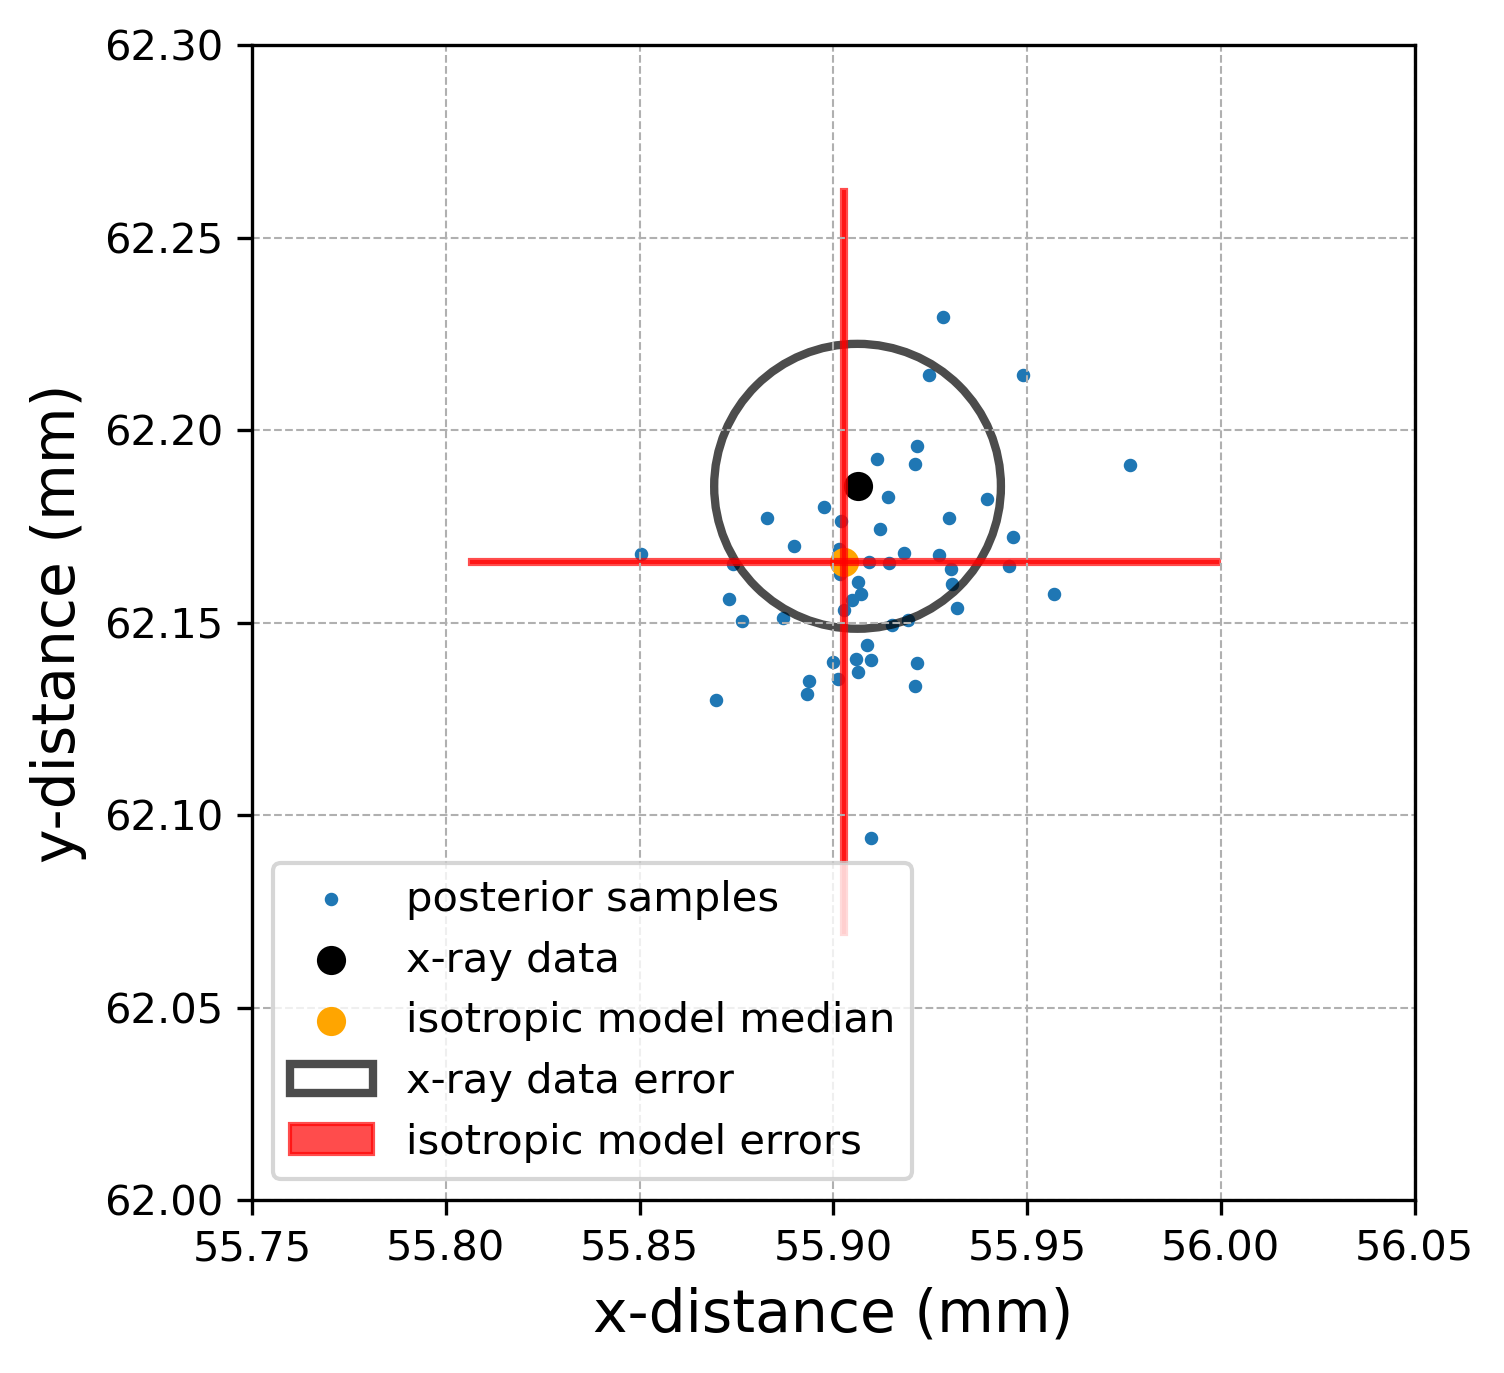

In [ ]:
# plot posterior predictive samples

# Find X-ray measurement (with error of 0.037mm)

circle = plt.Circle((X[37], Y[37]), 0.037, fill=False, edgecolor='black', linewidth=2, alpha=0.7, label='x-ray data error')

# plot xy errors

height = sigma[37]
width = 0.001

rectangle = plt.Rectangle((median_pred[0][37]-width/2, median_pred[1][37] - sigma[37]), width=width, height=2*height ,fill=True, color='red', linewidth=1, alpha=0.7)
rectangle2 = plt.Rectangle((median_pred[0][37]-sigma[37], median_pred[1][37] -width/2), width=2*height, height=width ,fill=True, color='red', linewidth=1, alpha=0.7,label = 'isotropic model errors')


# Create the plot
fig,axes = plt.subplots(1,1, figsize=(5,5))
fig.set_dpi(300)

axes.scatter(hole37[::2], hole37[1::2], s=5, label='posterior samples')
axes.scatter(X[37],Y[37], color='black', label='x-ray data')
axes.scatter(median_pred[0][37], median_pred[1][37], color='orange', label='isotropic model median')
axes.add_artist(circle)
axes.add_patch(rectangle)
axes.add_patch(rectangle2)

# Customize labels and title
axes.set_xlabel('x-distance (mm)', fontsize=14)

axes.set_ylabel('y-distance (mm)', fontsize=14)


# Add a grid and adjust appearance
axes.grid(True, which='both', linestyle='--', linewidth=0.5)

axes.set_xlim(55.75,56.05)
axes.set_ylim(62,62.3)


# Show the plot
plt.legend()

plt.show()



In [ ]:
# compute credible intervals 

medians = []
plus_minus = []

for i in range(101):
    for param, values in samples_isotropic.items():
            medians.append(np.median(values))
            lower = ((100 - i) / 2)
            upper = 100 - lower

            plus_minus.append(np.percentile(values, [lower, upper]))

[[np.float64(355.59107971191406), np.float64(355.59107971191406)],
 [np.float64(355.53269973754885), np.float64(355.65013671875)],
 [np.float64(355.497551574707), np.float64(355.690260925293)],
 [np.float64(355.44242126464843), np.float64(355.73384979248044)],
 [np.float64(355.38993896484374), np.float64(355.78662841796876)],
 [np.float64(355.35356216430665), np.float64(355.83761138916014)],
 [np.float64(355.2971713256836), np.float64(355.8858624267578)],
 [np.float64(355.2543338012695), np.float64(355.9228125)],
 [np.float64(355.21275024414064), np.float64(355.96840026855466)],
 [np.float64(355.1659875488281), np.float64(356.0039451599121)],
 [np.float64(355.12593841552734), np.float64(356.04237060546876)],
 [np.float64(355.0869343566894), np.float64(356.090094909668)],
 [np.float64(355.0379919433594), np.float64(356.1579321289062)],
 [np.float64(354.9922576904297), np.float64(356.20349273681643)],
 [np.float64(354.93356750488283), np.float64(356.23927642822264)],
 [np.float64(354.890

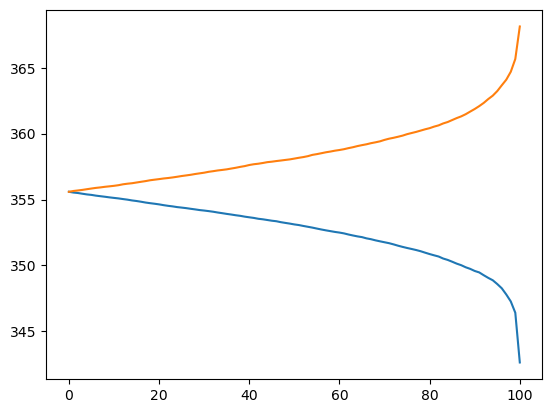

In [ ]:
plt.plot(plus_minus[0::27])

clean_output = [list(arr) for arr in plus_minus[0::27]]
clean_output


In [ ]:
# Gaussian fit to posterior on N

def gauss(N, N_bar, sigma_N):

    return 1/((2*np.pi)**(1/2)*sigma_N) * np.exp(- (N - N_bar)**2 / (2*sigma_N**2))

# search over days 340 - 370
N = np.linspace(342,368,100)

# isotropic model

N_bar_iso = 355.65 
sigma_N_iso = 3.73 

# radial-tangential model

N_bar_ali = 355.17
sigma_N_ali = 1.40

isotropic = gauss(N,N_bar_iso,sigma_N_iso)
aligned = gauss(N,N_bar_ali,sigma_N_ali)

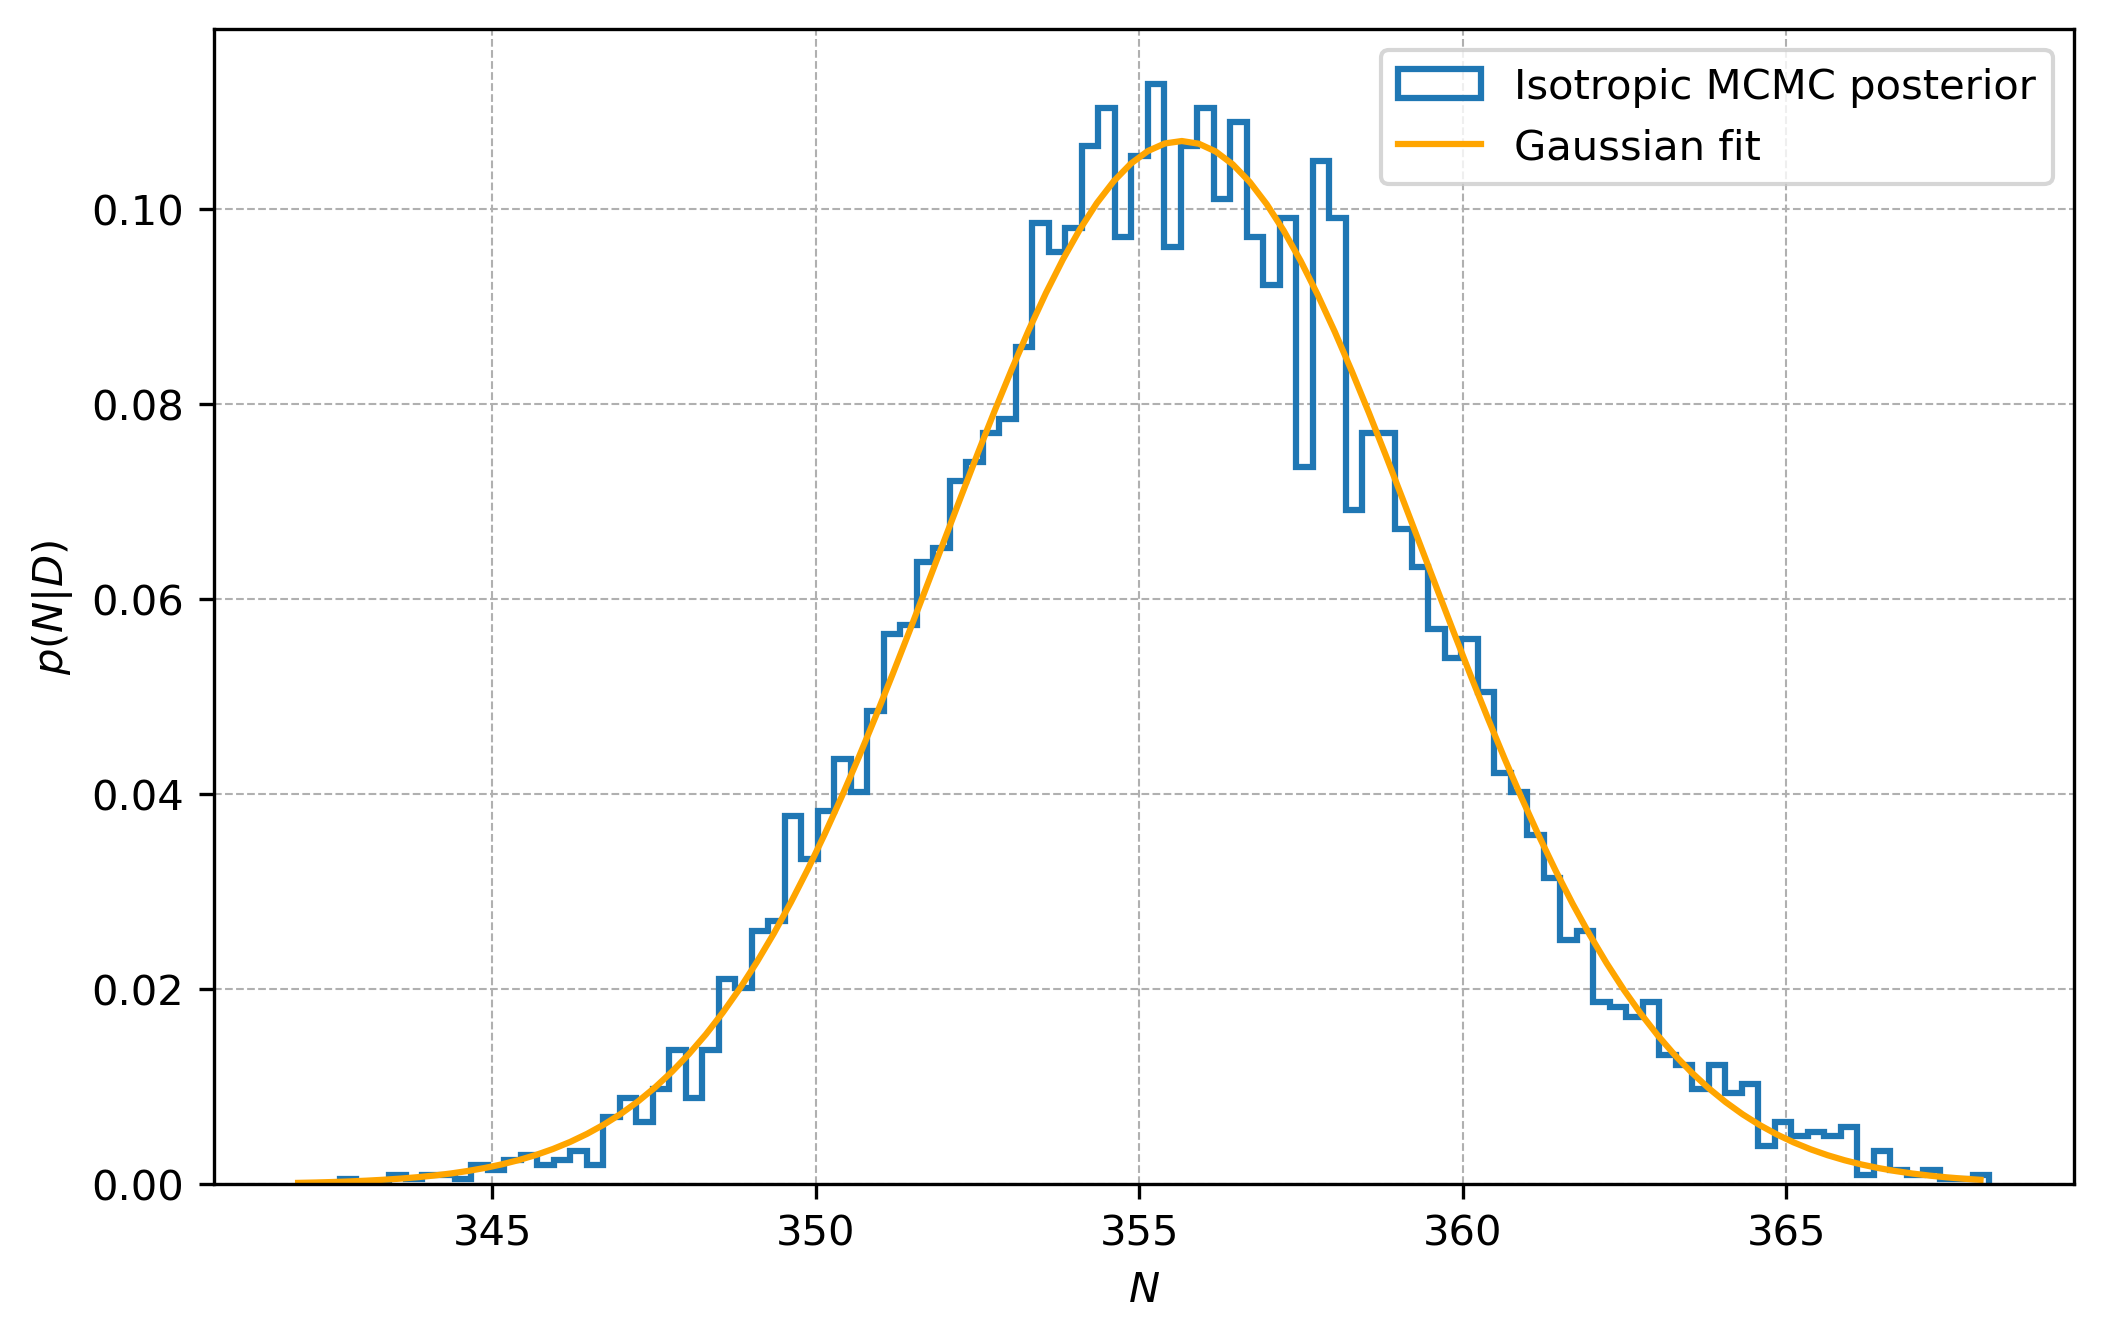

In [ ]:
posterior_N = mcmc_isotropic.get_samples()['N']

fig,ax = plt.subplots(figsize=(8,5))
fig.set_dpi(300)

ax.hist(posterior_N, bins=100, density=True, histtype='step',linewidth=1.5, label='Isotropic MCMC posterior')
ax.plot(N, isotropic, color='orange', label='Gaussian fit')

# Add a grid and adjust appearance
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

ax.set_xlabel('$N$')
ax.set_ylabel("$p(N | D)$")

plt.legend()
plt.show()
